# Project: Book Rating Prediction Model

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 1. Load dataset

In [33]:
# raise a warning when a bad line (a line with too many fields) is encountered and skip that line
df = pd.read_csv("books.csv", on_bad_lines='warn')

C:\Users\HP\AppData\Local\Temp\ipykernel_12416\79441328.py:2: ParserWarning: Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13

  df = pd.read_csv("books.csv", on_bad_lines='warn')


In [34]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


## 2. Dataset analysis

In [35]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


#### Data distribution

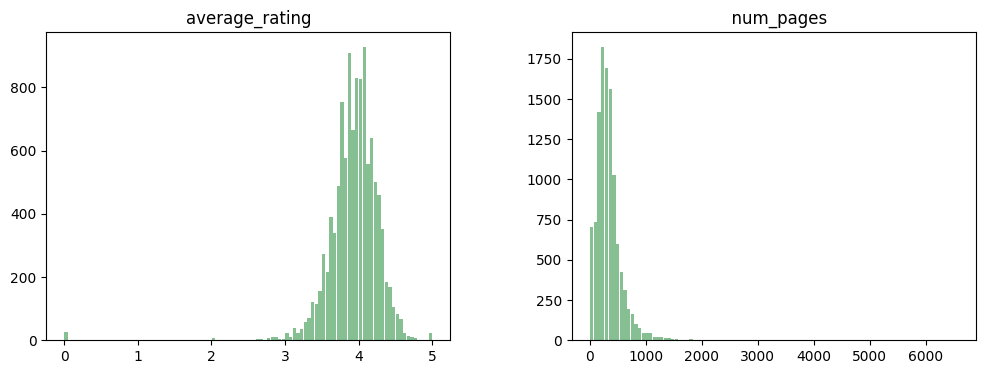

In [36]:
df.hist(column=["average_rating", "  num_pages"], 
        bins=100, grid=False, figsize=(12,4), color='#86bf91', rwidth=0.9)
plt.show()

#### Plotting each dimension against the target

In [37]:
df[["  num_pages", "average_rating", "ratings_count"]].corr()

,num_pages,average_rating,ratings_count
num_pages,1.000000,0.150477,0.034337
average_rating,0.150477,1.000000,0.038224
ratings_count,0.034337,0.038224,1.000000


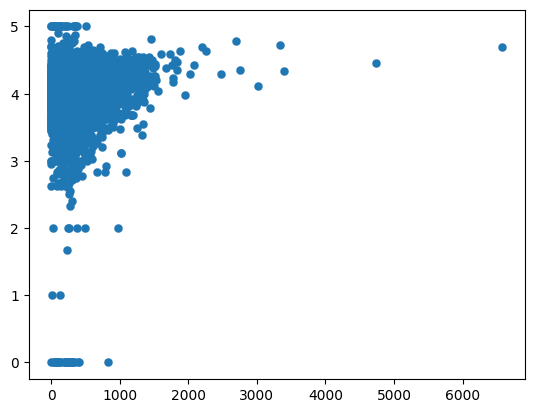

In [38]:
plt.scatter(df["  num_pages"], df["average_rating"], linewidths=0.1)

In [39]:
(df['average_rating'] < 1).sum()

25

C:\Users\HP\AppData\Local\Temp\ipykernel_12416\996516365.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, language_counts[i], str(language_counts[i]), ha='center', va='bottom')


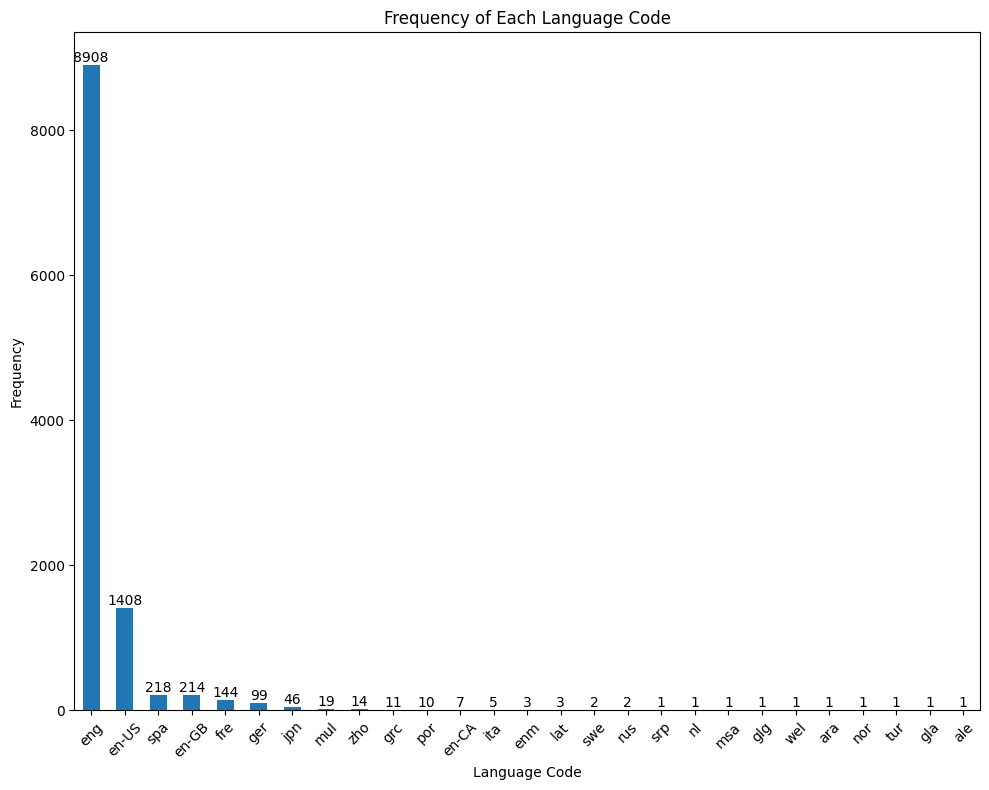

In [40]:
# Counting the frequency of each language code
language_counts = df['language_code'].value_counts()

# Creating a bar chart for the language codes
plt.figure(figsize=(10, 8))
language_counts.plot(kind='bar')
plt.title('Frequency of Each Language Code')
plt.xlabel('Language Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for i in range(len(language_counts)):
    plt.text(i, language_counts[i], str(language_counts[i]), ha='center', va='bottom')
    
plt.tight_layout()

## 3 Pre-Processing

#### Removing irrelevant feature

In [41]:
df = df.drop(['bookID', 'title', 'isbn', 'isbn13'], axis = 1)

#### Exclude languages with fewer than 99 books from the dataset

In [42]:
df['language_code'].replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'}, inplace=True)
language_counts = df['language_code'].value_counts()
df = df[~df['language_code'].isin(language_counts[language_counts < 99].index)]

C:\Users\HP\AppData\Local\Temp\ipykernel_12416\3057680666.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['language_code'].replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'}, inplace=True)


In [43]:
df['language_code'].value_counts()

language_code
eng    10537
spa      218
fre      144
ger       99
Name: count, dtype: int64

#### Removing unnecessary spaces

In [44]:
df.rename(columns=lambda x: x.strip(), inplace=True)

#### Filter out books that have received too few ratings

In [45]:
df.query("ratings_count >= 20", inplace=True)

In [46]:
df.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,9941.000000,9941.000000,9.941000e+03,9941.000000
mean,3.947065,343.476612,2.006989e+04,606.212956
std,0.271735,240.175589,1.188209e+05,2718.392407
min,2.400000,0.000000,2.000000e+01,0.000000
25%,3.780000,206.000000,2.080000e+02,16.000000
50%,3.960000,304.000000,1.101000e+03,65.000000
75%,4.130000,419.000000,6.253000e+03,293.000000
max,4.820000,6576.000000,4.597666e+06,94265.000000


In [47]:
def preprocess_author_name(author_name):
    # Remove spaces in the author's name and delete characters before the '/'
    return author_name.replace(" ", "").split("/")[0]

df['authors'] = df['authors'].apply(lambda x: preprocess_author_name(x))

In [48]:
df.nunique()

authors               3732
average_rating         191
language_code            4
num_pages              979
ratings_count         5269
text_reviews_count    1822
publication_date      3381
publisher             1919
dtype: int64

#### Date encoding

In [49]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

In [50]:
print(len(df[df['publication_date'].isnull()]))

1


In [51]:
df.dropna(subset=['publication_date'], inplace=True)
df['publication_date'] = df['publication_date'].apply(lambda x: x.timestamp())

In [52]:
def binary_encoder(df, column_name):
    encoder = preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[[column_name]])
    encoded_column_name = encoder.get_feature_names_out([column_name])
    encoded_df = pd.DataFrame(encoded, columns=encoded_column_name)
    df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    return df

In [53]:
# df = binary_encoder(df, 'publisher')
df = binary_encoder(df, 'authors')
df = binary_encoder(df, 'language_code')
df.head()

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_A.B.Yehoshua,authors_A.J.Jacobs,authors_A.M.Homes,authors_A.N.Roquelaure,...,authors_ZoraNealeHurston,authors_ZoëHeller,authors_bellhooks,authors_ÅsneSeierstad,authors_ÉmileZola,authors_Éric-EmmanuelSchmitt,language_code_eng,language_code_fre,language_code_ger,language_code_spa
0,4.57,652,2095690,27591,1.158365e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.49,870,2153167,29221,1.093997e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4.42,352,6333,244,1.067645e+09,Scholastic,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.56,435,2339585,36325,1.083370e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.78,2690,41428,164,1.095034e+09,Scholastic,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Cleaned dataset

In [54]:
df.to_csv('books_cleaned.csv', index=False)

## Linear regression

In [55]:
X = df.drop(['average_rating', 'publisher'], axis = 1)
y = df['average_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
linReg = LinearRegression()
linReg.fit(X_train, y_train)

LinearRegression()

In [56]:
y_pred = linReg.predict(X_test)

In [57]:
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, y_pred))
print("Coefficient de détermination (R-squared) :", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.16576012709194457
Mean Squared Error (MSE): 0.0493022003929724
Coefficient de détermination (R-squared) : 0.300054302484165


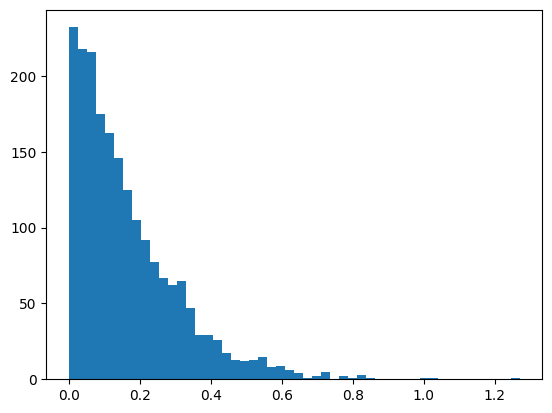

In [58]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.show()

## Decision Tree

In [64]:
from sklearn.ensemble import RandomForestRegressor
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Évaluer le modèle
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, predictions))
print("Coefficient de détermination (R-squared) :", r2_score(y_test, predictions))


Mean Absolute Error (MAE): 0.18966272635814888
Mean Squared Error (MSE): 0.06138109187625757
Coefficient de détermination (R-squared) : 0.2099334577776537


Model Performance: Absolute Error Distribution

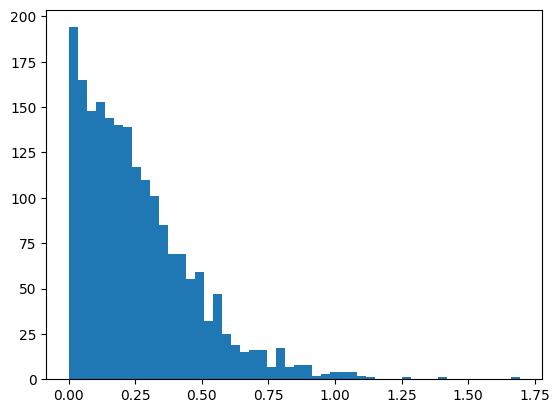

In [63]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.show()

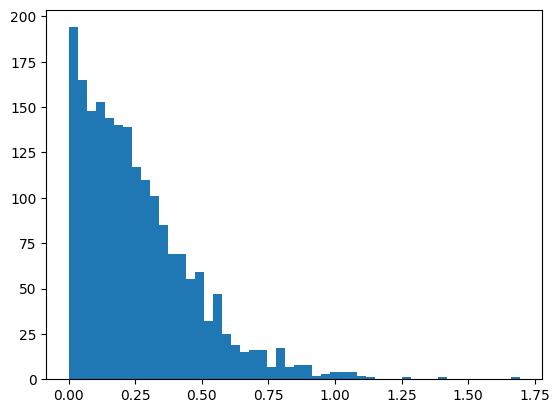

In [61]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.show()

## Neural network

In [69]:
from sklearn.discriminant_analysis import StandardScaler
import tensorflow as tf
from tensorflow import keras
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but recommended for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the FNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer, no activation function for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print('Mean Squared Error (MSE) on test data:', loss)

Epoch 1/50
199/199 [==============================] - 7s 17ms/step - loss: 1.9003 - val_loss: 0.4954
Epoch 2/50
199/199 [==============================] - 7s 33ms/step - loss: 0.6684 - val_loss: 1.1291
Epoch 3/50
199/199 [==============================] - 5s 27ms/step - loss: 0.1676 - val_loss: 1.2900
Epoch 4/50
199/199 [==============================] - 5s 26ms/step - loss: 0.1060 - val_loss: 1.4363
Epoch 5/50
199/199 [==============================] - 5s 24ms/step - loss: 0.0907 - val_loss: 1.5883
Epoch 6/50
199/199 [==============================] - 6s 29ms/step - loss: 0.0883 - val_loss: 1.7174
Epoch 7/50
199/199 [==============================] - 4s 19ms/step - loss: 0.0802 - val_loss: 1.8612
Epoch 8/50
199/199 [==============================] - 4s 21ms/step - loss: 0.0797 - val_loss: 1.9631
Epoch 9/50
199/199 [==============================] - 3s 16ms/step - loss: 0.0759 - val_loss: 2.0601
Epoch 10/50
199/199 [==============================] - 4s 19ms/step - loss: 0.0758 - val_lo

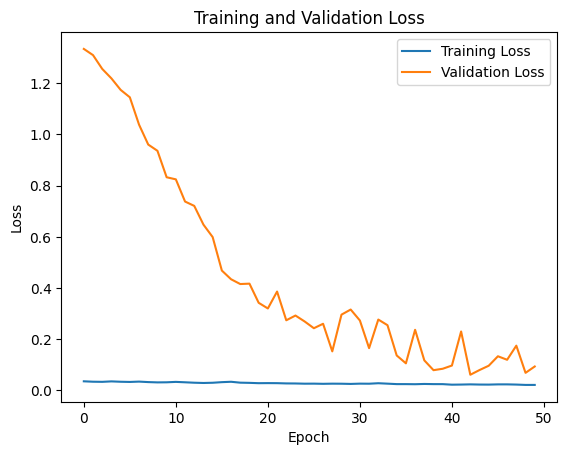

63/63 [==============================] - 1s 8ms/step


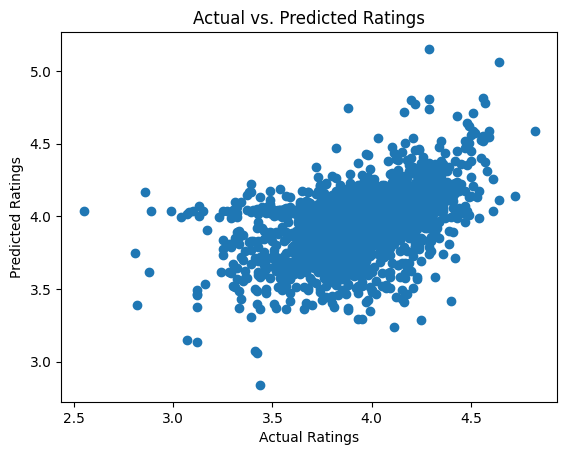

In [71]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot predicted vs. actual ratings
y_pred = model.predict(X_test_scaled)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()
